# Standings Test
First we establish a valid oauth token below:

In [37]:
from yahoo_oauth import OAuth2
oauth = OAuth2(None, None, from_file='../oauth2.json')

[2019-10-22 22:13:12,958 DEBUG] [yahoo_oauth.yahoo_oauth.__init__] Checking 
[2019-10-22 22:13:12,960 DEBUG] [yahoo_oauth.yahoo_oauth.token_is_valid] ELAPSED TIME : 3856.5246908664703
[2019-10-22 22:13:12,961 DEBUG] [yahoo_oauth.yahoo_oauth.token_is_valid] TOKEN HAS EXPIRED
[2019-10-22 22:13:12,961 DEBUG] [yahoo_oauth.yahoo_oauth.refresh_access_token] REFRESHING TOKEN


This will run more frequently - this will check if the token is valid, if not, refresh. Then, we can try to download info from yahoo.

[2019-10-22 22:48:59,209 DEBUG] [yahoo_oauth.yahoo_oauth.token_is_valid] ELAPSED TIME : 2146.246522665024
[2019-10-22 22:48:59,209 DEBUG] [yahoo_oauth.yahoo_oauth.token_is_valid] TOKEN IS STILL VALID


,Team Names,Wins,Losses,Ties,Cohort,Leagues,mean,std,min,25%,50%,75%,max,Points For
1,Summer's Team,6,1,0,25,2,120.168571,27.054426,68.26,113.59,117.04,140.62,147.46,841.18
2,Rachel's Team,5,2,0,QG,1,134.385714,19.417527,95.94,129.82,144.90,146.26,147.70,940.70
3,Ball istic Missiles,5,2,0,26,3,133.085714,29.873167,90.92,114.96,135.46,151.52,172.26,931.60
4,Six Sigmas,5,2,0,25,2,131.114286,30.850426,106.22,110.72,118.62,138.99,193.54,917.80
5,I Eat Mop,5,2,0,30,2,121.311429,30.054796,63.02,111.03,132.44,140.57,150.52,849.18
6,Haskin' For Trouble,5,2,0,23,1,118.462857,29.086699,89.10,95.14,111.40,138.67,161.12,829.24
7,Matthew Masison,5,2,0,27,3,113.922857,36.052540,77.66,87.22,97.96,136.99,173.42,797.46
8,Action Macklin,4,3,0,QG,1,124.828571,30.280539,88.70,101.15,126.22,146.13,164.32,873.80
9,Bobby's Team,4,3,0,21,3,123.157143,30.270971,81.46,105.02,111.06,146.87,165.80,862.10
10,Mike's Team,4,3,0,33,1,122.637143,18.237231,89.42,117.56,122.58,131.27,148.80,858.46


Leagues
1    86.199129
3    74.012707
2    68.796915
Name: Actual, dtype: float64

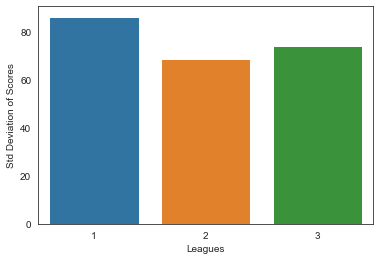

Cohort
26    931.600000
QG    865.093333
25    830.230000
29    801.990000
27    797.460000
33    792.500000
23    785.330000
30    784.120000
21    778.690000
24    740.120000
32    730.160000
Name: Actual, dtype: float64

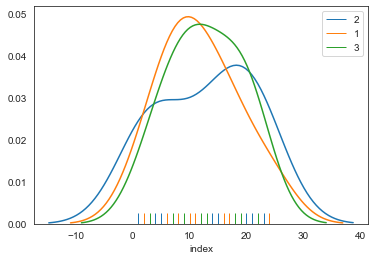

In [60]:
%matplotlib inline
from bs4 import BeautifulSoup
import xml.etree.ElementTree as et 
import pandas as pd 

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

sns.set_style("white")


if not oauth.token_is_valid():
    oauth.refresh_access_token()
    
df_cols = ["projected points"]
out_df = pd.DataFrame(columns = df_cols)

num_teams = 8

league_ids = [1118202, 1110495, 1112355]

team_name_list = []
dist_series = pd.Series()
series_total = pd.Series()
series_wins = pd.Series()
series_losses = pd.Series()
series_ties = pd.Series()

weeks = 7

for league_num, league_id in enumerate(league_ids):
    for week in range(1, weeks+1):
        url = "https://fantasysports.yahooapis.com/fantasy/v2/league/nfl.l."+str(league_id)+"/scoreboard;week=" + str(week)
        # url = "https://fantasysports.yahooapis.com/fantasy/v2/league/nfl.l.1118202/standings"
        # probably migrate to scoreboard when there is data... but unsure
        # url = "https://fantasysports.yahooapis.com/fantasy/v2/league/nfl.l.854917/scoreboard"
        # https://fantasysports.yahooapis.com/fantasy/v2/team/223.l.431.t.1/matchups;weeks=1,5
        payload = ""
        response = oauth.session.get(url, params=payload)

        # we only want to process data if there's data to pass.
        if not response.status_code == 200:
            print("Status Code Not Valid")
            print(response.text)
        else:

        #   XML Samples which are searchable can be found here: https://developer.yahoo.com/fantasysports/guide/

            soup = BeautifulSoup(response.text, 'lxml')
        #     Remove new line formatting from html to prevent confusion
            clean = str(soup).replace('\n', '')
        #     print(clean)
        #     print(soup.prettify())

        #  Get team Names:
        #     select all name tags beneath team tags
            s_team_names = soup.select('team_projected_points total')
        #     extract the text from the entire tag
            s_team_names = list(map(lambda x: float(x.text), s_team_names))
    #         print(s_team_names)
        #     place that in a fancy little pandas series
            dist_series = dist_series.append(pd.Series(s_team_names), ignore_index=True)
    #         print(dist_series)

            s_total = soup.select('team_points total')
            s_total = list(map(lambda x: float(x.text), s_total))
            series_total = series_total.append(pd.Series(s_total), ignore_index=True)

            tn_l = soup.select('team name')
            tn_l = list(map(lambda x: x.text, tn_l))
            team_name_list+=tn_l
    url = "https://fantasysports.yahooapis.com/fantasy/v2/league/nfl.l."+ str(league_id) +"/standings"
    response = oauth.session.get(url)
    if not response.status_code == 200:
        print("Status Code 2nd request Not Valid")
        print(response.text)
    else:
        soup = BeautifulSoup(response.text, 'lxml')
#         print(soup.prettify())
        s_wl_index = soup.select('team name')
        s_wl_index = list(map(lambda x: x.text, s_wl_index))
#         wl_index.append(s_wl_index)

        s_wins = soup.select('wins')
        s_wins = list(map(lambda x: int(x.text), s_wins))
        series_wins = series_wins.append(pd.Series(s_wins, index=s_wl_index))

        s_losses = soup.select('losses')
        s_losses = list(map(lambda x: int(x.text), s_losses))
        series_losses = series_losses.append(pd.Series(s_losses, index=s_wl_index))

        s_ties = soup.select('ties')
        s_ties = list(map(lambda x: int(x.text), s_ties))
        series_ties = series_ties.append(pd.Series(s_ties, index=s_wl_index))

cohorts = pd.read_csv('../cohorts.csv', index_col=0)
leagues = pd.read_csv('../leagues.csv', index_col=0)

data = {"Actual": series_total, "Projected": dist_series, "Team Names": team_name_list}
final_df = pd.DataFrame(data).set_index("Team Names")

final_df['Wins'] = series_wins
final_df['Losses'] = series_losses
final_df['Ties'] = series_ties

df1 = final_df.groupby('Team Names')['Actual'].describe().drop("count", axis=1)
df2 = final_df.groupby('Team Names')['Actual'].sum()

df1["Points For"] = df2

df1['Wins'] = series_wins
df1['Losses'] = series_losses
df1['Ties'] = series_ties
df1['Cohort'] = cohorts
df1['Leagues'] = leagues
df1_cols = df1.columns.tolist()
df1_cols = df1_cols[-5:] + df1_cols[:-5]

df1 = df1[df1_cols]

df1 = df1.sort_values(by=['Wins',"Points For"], ascending=[False,False])
df1 = df1.reset_index()
df1.index +=1


display(df1)
# The order is different int this call (by standing), so index must be assigned in the series then matched up with the final df
df2 = df2.to_frame()
df3 = df2.copy()

df3['Leagues'] = leagues
df3 = df3.groupby('Leagues')['Actual'].std().sort_values(ascending=False)
display(df3)
sns.barplot(x=df3.index, y=df3.values).set(ylabel="Std Deviation of Scores")

plt.show()

df2['Cohort'] = cohorts
df2 = df2.groupby('Cohort')['Actual'].mean().sort_values(ascending=False)
display(df2)
# sns.barplot(x=df2.index, y=df2.values).set(ylabel="Average Total Scores")


# sns.boxplot(data=final_df, order=["Projected", "Actual"])
# sns.kdeplot(final_df.projected, final_df.actual)
# sns.distplot(dist_series, bins=12);


# sns.jointplot(data=final_df, y="Projected", x="Actual", kind="reg", label="Team Names")
# final_df.corr(method="pearson")


df4 = df1.copy()
unique_vals = df4['Leagues'].unique()
df4 = df4.reset_index()
my_lists = [df4[df4['Leagues']==val] for val in unique_vals]


for l in my_lists:
    pl = l.loc[:,'index']
    sns.distplot(pl, hist=False, rug=True)

plt.legend(labels=unique_vals)
plt.show()